### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab

In [3]:
import numpy as np
import feather
from datetime import datetime
import re

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Import Data & Clean

In [6]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv')
df.head()

/Users/zeb.zhao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,! LTD,08209948,NaN,NaN,METROHOUSE 57 PEPPER ROAD,HUNSLET,LEEDS,YORKSHIRE,NaN,LS10 2RU,Private Limited Company,Active,United Kingdom,NaN,11/09/2012,30.0,9.0,30/06/2018,30/09/2016,DORMANT,09/10/2016,11/09/2015,0,0,0,0,99999 - Dormant Company,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08209948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/09/2019,11/09/2017
1,!NNOV8 LIMITED,11006939,NaN,NaN,C/O FRANK HIRTH 1ST FLOOR,236 GRAY'S INN ROAD,LONDON,NaN,UNITED KINGDOM,WC1X 8HB,Private Limited Company,Active,United Kingdom,NaN,11/10/2017,31.0,3.0,11/07/2019,NaN,NO ACCOUNTS FILED,08/11/2018,NaN,0,0,0,0,62090 - Other information technology service a...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/11006939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24/10/2019,NaN
2,!NSPIRED LTD,SC421617,NaN,NaN,26 POLMUIR ROAD,NaN,ABERDEEN,NaN,UNITED KINGDOM,AB11 7SY,Private Limited Company,Active,United Kingdom,NaN,11/04/2012,30.0,3.0,30/12/2018,30/03/2017,TOTAL EXEMPTION FULL,09/05/2017,11/04/2016,0,0,0,0,70229 - Management consultancy activities othe...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/SC421617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/04/2020,11/04/2017
3,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,55A HIGH STREET,NaN,SILSOE,BEDFORDSHIRE,NaN,MK45 4EW,Private Limited Company,Active,United Kingdom,NaN,30/07/2014,31.0,7.0,30/04/2019,31/07/2017,NaN,27/08/2016,30/07/2015,0,0,0,0,58190 - Other publishing activities,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09152972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/08/2020,30/07/2017
4,!OBAC LIMITED,FC031362,NaN,NaN,1ST AND 2ND FLOORS ELIZABETH HOUSE,LES RUETIES BRAYES,ST PETER PORT,GUERNSEY,GUERNSEY,GY1 1EW,Other company type,Active,CHANNEL ISLANDS,NaN,30/11/2012,31.0,12.0,NaN,31/12/2016,GROUP,NaN,NaN,0,0,0,0,None Supplied,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/FC031362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def clean(df):
    wdf = df.dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\-\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')\
        .str.replace('(LTD|INC|PLC)', '')\
        .str.replace('\\b[A-Z0-9]\\b', '')
    wdf['SICC'] = SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '74990') & (SICC != '99999') & (SICC != '7499') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [10]:
wdf = clean(df)
len(wdf)

2417811

### Remove Unknown Names

In [18]:
wdf['WordSum'] = wdf.CompanyName.apply(sum_of_custom_tokenize)
(wdf.WordSum == 0).sum()

284760

In [19]:
# Remove super short names
(wdf.CompanyName.str.len() < 4).sum()

2022

In [20]:
wdf[wdf.WordSum == 0].head(25)

,CompanyName,SICCode.SicText_1,SICC,WordSum
2,!NSPIRED,70229 - Management consultancy activities othe...,70229,0
8,,70229 - Management consultancy activities othe...,70229,0
77,EVEERGE,2875 - Manufacture other fabricated metal prod...,2875,0
109,LANDLIMES,08120 - Operation of gravel and sand pits; min...,08120,0
147,PERFECTCLEAN,81299 - Other cleaning services,81299,0
329,DESIGNBLU,82990 - Other business support service activit...,82990,0
373,FISHFRYERS,68209 - Other letting and operating of own or ...,68209,0
385,SGWENNU,90020 - Support activities to performing arts,90020,0
555,:OOMLOUT:,"47990 - Other retail sale not in stores, stall...",47990,0
613,7734,62020 - Information technology consultancy act...,62020,0


In [21]:
wdf = wdf[(wdf.WordSum > 0) & (wdf.CompanyName.str.len() > 3) & (wdf.SICC.str.len() == 5)]
len(wdf)

2113119

### Feature Engineering

In [22]:
wdf['Industry'] = wdf['SICCode.SicText_1'].str.split(' - ').str[0].str[0:3]
wdf['SICText'] = wdf['SICCode.SicText_1']
wdf = wdf.drop('SICCode.SicText_1', axis=1)
wdf.head()

,CompanyName,SICC,WordSum,Industry,SICText
3,!NVERTD DESIGNS,58190,5089,581,58190 - Other publishing activities
5,!OBAC UK,70229,2046,702,70229 - Management consultancy activities othe...
6,!YOZO FASS,90010,349123,900,90010 - Performing arts
11,243 RUGBY ROAD MANAGEMENT COMPANY,98000,30428,980,98000 - Residents property management
12,309 WEST END LANE MANAGEMENT,98000,35440,980,98000 - Residents property management


### Check for Class Imbalance

In [10]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).CompanyName.count().sort_values(ascending=False)
    print('AVG: ', classes.mean())
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

AVG:  7740.3626373626375


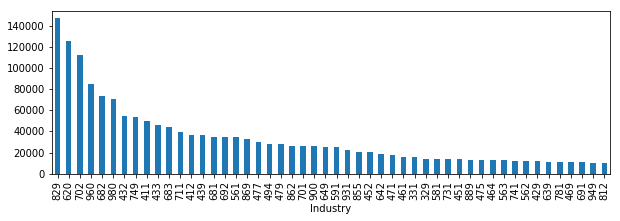

In [11]:
plot_frequency(wdf, 'Industry')

AVG:  2902.635989010989


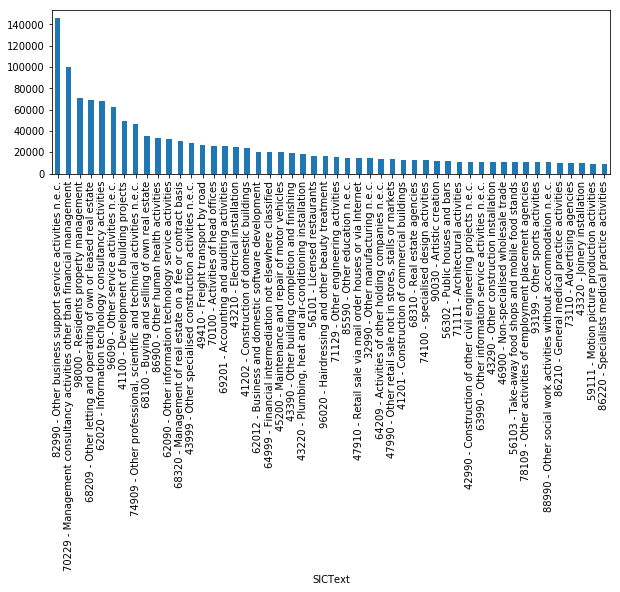

In [12]:
plot_frequency(wdf, 'SICText')

In [19]:
min_class_count = 2500
classes = wdf.groupby(['Industry']).count().sort_values('CompanyName', ascending=False)
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 2500 samples: 159/273


In [20]:
classes[classes.CompanyName < min_class_count].head()

,CompanyName,SICC,WordSum,SICText
Industry,,,,
474,2465,2465,2465,2465
732,2424,2424,2424,2424
582,2380,2380,2380,2380
139,2316,2316,2316,2316
521,2314,2314,2314,2314


In [21]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName    122318
SICC           122318
WordSum        122318
SICText        122318
dtype: int64

### Resample Data

In [22]:
to_replace = classes[classes.CompanyName < min_class_count].index

In [23]:
wdf['Industry'] = wdf['Industry'].replace(to_replace, '0')

In [24]:
# Remove unknown data
wdf = wdf[wdf['Industry'] != '0']
len(wdf)

1990801

AVG:  17463.166666666668


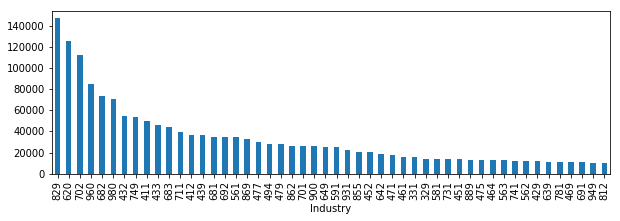

In [25]:
plot_frequency(wdf, 'Industry')

AVG:  4964.59102244389


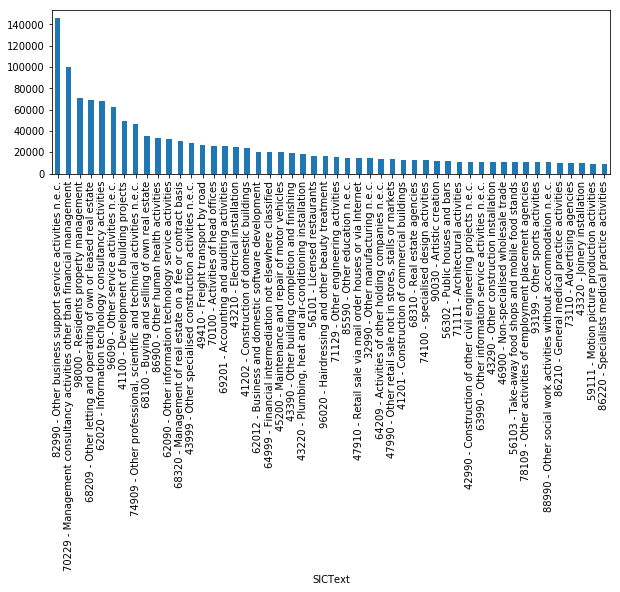

In [27]:
plot_frequency(wdf, 'SICText')

In [26]:
def resample_classes(df, groupby, samples):
    classes = wdf.groupby([groupby]).CompanyName.count()
    freqs = dict(5000/classes)
    freq = df[groupby].map(freqs)
    criteria = np.random.rand(len(df)) < freq
    return df[criteria]

In [28]:
rwdf = resample_classes(wdf, 'Industry', 5000)

AVG:  4532.017543859649


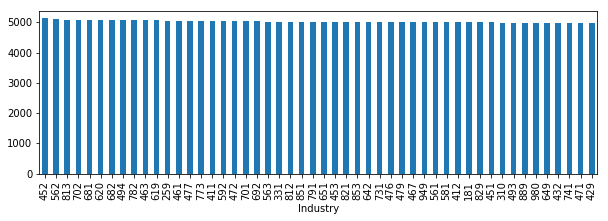

In [29]:
plot_frequency(rwdf, 'Industry')

AVG:  1291.625


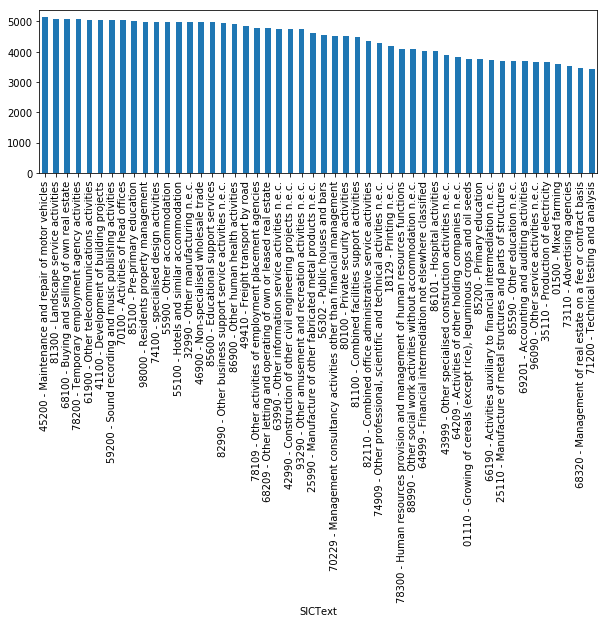

In [30]:
plot_frequency(rwdf, 'SICText')

### Pickle Working Set

In [23]:
feather.write_dataframe(wdf, 'wdf4m.feather')

In [6]:
wdf = feather.read_dataframe('wdf4m.feather')
wdf.head()

,CompanyName,SICC,WordSum,Industry,SICText
0,!NVERTD DESIGNS,58190,5089,581,58190 - Other publishing activities
1,!OBAC UK,70229,2046,702,70229 - Management consultancy activities othe...
2,!YOZO FASS,90010,349123,900,90010 - Performing arts
3,243 RUGBY ROAD MANAGEMENT COMPANY,98000,30428,980,98000 - Residents property management
4,309 WEST END LANE MANAGEMENT,98000,35440,980,98000 - Residents property management


### Label Encoding

In [31]:
industry_encoder = LabelEncoder()
industry_encoder.fit(rwdf['Industry'])
encoded_industry = industry_encoder.transform(rwdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(516650, 114)

In [32]:
num_industries = industry_labels.shape[1]

### Text Encoding

In [33]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [34]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.100d.txt', embedding_dim=100)

In [35]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [36]:
def sum_of_custom_tokenize(d):
    return sum(word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split())

In [37]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize('This is an apple inc 10'))
print(custom_tokenize('what is this, an apple ltd?'))
vocab_size, embedding_dim

[37, 14, 29, 3292, 15231, 206]
[102, 14, 37, 29, 3292, 8196]


(400001, 100)

In [38]:
encoded_company_names = [custom_tokenize(d) for d in rwdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [40]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(516650, 516650)

### Train/Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, industry_labels, test_size=0.2, random_state=42)
y_train.shape

(413320, 114)

### Model

In [86]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(64, 3, activation='relu', padding='same'))
model.add(Convolution1D(64, 3, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(num_industries, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           40000100  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 64)            19264     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 640)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 114)               73074     
Total params: 40,104,790
Trainable params: 104,690
Non-trainable params: 40,000,100
__________________________________________________________

### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [87]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-fd%s-industry-resampled-cnn2x64-flatten-%s' % (
    embedding_dim, num_industries, date_suffix)
temp_folder

'tmp/GloVe100-fd114-industry-resampled-cnn2x64-flatten-2018-03-22 16-49-24'

### Train Model

In [88]:
model.fit(
    X_train, y_train, epochs=16, batch_size=50,
    validation_data=(X_test, y_test),
    callbacks=[TensorBoard(log_dir=temp_folder)])

Train on 413320 samples, validate on 103330 samples
Epoch 1/16
413320/413320 [==============================] - 39s 94us/step - loss: 3.3622 - acc: 0.2268 - val_loss: 3.1455 - val_acc: 0.2654
Epoch 2/16
413320/413320 [==============================] - 38s 92us/step - loss: 3.1335 - acc: 0.2684 - val_loss: 3.0818 - val_acc: 0.2778
Epoch 3/16
413320/413320 [==============================] - 38s 93us/step - loss: 3.0825 - acc: 0.2779 - val_loss: 3.0729 - val_acc: 0.2809
Epoch 4/16
413320/413320 [==============================] - 39s 95us/step - loss: 3.0571 - acc: 0.2823 - val_loss: 3.0602 - val_acc: 0.2835
Epoch 5/16
413320/413320 [==============================] - 38s 92us/step - loss: 3.0397 - acc: 0.2857 - val_loss: 3.0515 - val_acc: 0.2834
Epoch 6/16
413320/413320 [==============================] - 38s 92us/step - loss: 3.0292 - acc: 0.2874 - val_loss: 3.0496 - val_acc: 0.2861
Epoch 7/16
413320/413320 [==============================] - 38s 93us/step - loss: 3.0201 - acc: 0.2890 - val

### Testing/Validation

In [89]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

103330/103330 [==============================] - 5s 49us/step


0.29105777605729216

In [90]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
cm = confusion_matrix(y_pred, y_labels)

In [91]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.291057776057


In [120]:
def plot_confusion_matrix(cm, encoder):
    pylab.figure(figsize=(10,10))
    cm = cm/cm.sum(axis=0)
    dim, _ =cm.shape
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.5)
    ax = pylab.gca()
    ax.set_xticks(range(dim))
    ax.set_xticklabels(encoder.inverse_transform(pd.Series(range(dim))), rotation='vertical')
    ax.set_yticks(range(dim))
    ax.set_yticklabels(encoder.inverse_transform(pd.Series(range(dim))))
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

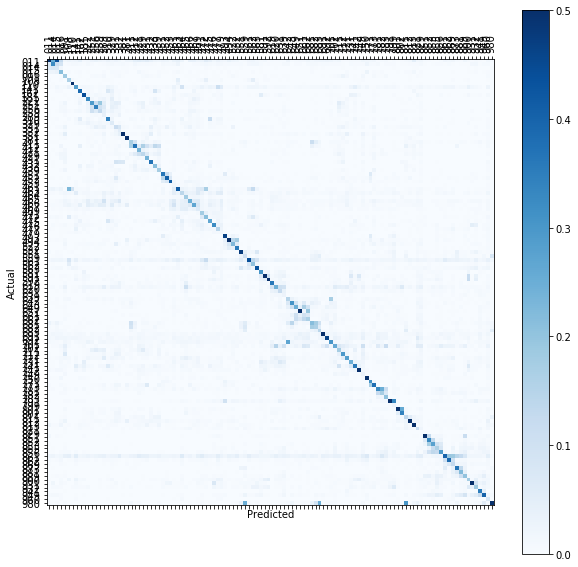

In [121]:
plot_confusion_matrix(cm, industry_encoder)

In [94]:
def acc_per_class(cm, encoder):
    cm_scaled = cm/cm.sum(axis=0)
    acc = pd.Series(np.diag(cm_scaled))
    acc = acc.reset_index()
    acc['acc'] = acc[0]
    acc['class'] = encoder.inverse_transform(acc.index)
    acc['total'] = cm.sum(axis=0)
    return acc[['class', 'acc', 'total']].set_index('class').sort_values('acc', ascending=False)

In [95]:
acc_per_class(cm, industry_encoder)

,acc,total
class,,
980,0.717684,967
791,0.664688,1011
851,0.634298,968
110,0.625969,516
351,0.620140,1003
750,0.563492,630
691,0.552391,983
592,0.548387,961
494,0.539303,1005


### Test with Original Sampling

In [69]:
industry_encoder = LabelEncoder()
industry_encoder.fit(wdf['Industry'])
encoded_industry = industry_encoder.transform(wdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(1990801, 114)

In [72]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [73]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(1990801, 1990801)

In [75]:
loss, accuracy = model.evaluate(encoded_company_names, industry_labels)
accuracy

1990801/1990801 [==============================] - 66s 33us/step


0.215933184683054

In [76]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
cm = confusion_matrix(y_pred, y_labels)

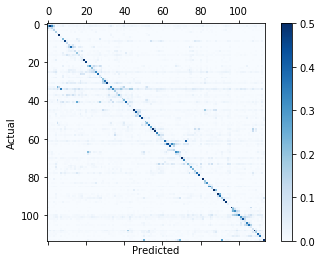

In [77]:
plot_confusion_matrix(cm, [])

In [78]:
acc_per_class(cm, industry_encoder)

,acc,total
class,,
980,0.694933,967
851,0.635331,968
691,0.573754,983
351,0.573280,1003
591,0.562955,961
110,0.562016,516
931,0.561366,937
493,0.558854,977
791,0.531157,1011


### Save Model

In [96]:
model.save('models/Trial8-GloVe100-Stacked-4m-CNN-acc%0.4f.h5' % accuracy)

### Play with Model

In [138]:
SIC_df = pd.read_csv('SIC07_CH_condensed_list_en.csv', dtype={'SIC Code': 'object'})

In [156]:
def pretext(precode):
    return '\n'.join('\t\t%s\t%s' % (value['SIC Code'], value.Description[:100]) 
                     for i, value in SIC_df[SIC_df['SIC Code'].str.startswith(precode)].iterrows())

In [ ]:
while True:
    name = input()
    if not name:
        break
    encoded_company_name = pad_sequences([custom_tokenize(name)], maxlen=maxlen, padding='post')
    pred = model.predict(encoded_company_name).flatten()
    probas = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)[:3]
    total = sum(pred)
    for i, p in probas:
        code = industry_encoder.inverse_transform(i)
        print('\t%0.2f%%' % (p/total*100))
        print(pretext(code))

bob's hair salon
	98.12%
		96010	Washing and (dry-)cleaning of textile and fur products
		96020	Hairdressing and other beauty treatment
		96030	Funeral and related activities
		96040	Physical well-being activities
		96090	Other service activities n.e.c.
	0.69%
		47910	Retail sale via mail order houses or via Internet
		47990	Other retail sale not in stores, stalls or markets
	0.35%
		46410	Wholesale of textiles
		46420	Wholesale of clothing and footwear
		46431	Wholesale of audio tapes, records, CDs and video tapes and the equipme
		46439	Wholesale of radio, television goods & electrical household appliances
		46440	Wholesale of china and glassware and cleaning materials
		46450	Wholesale of perfume and cosmetics
		46460	Wholesale of pharmaceutical goods
		46470	Wholesale of furniture, carpets and lighting equipment
		46480	Wholesale of watches and jewellery
		46491	Wholesale of musical instruments
		46499	Wholesale of household goods (other than musical instruments) n.e.c.
bob's super